In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer 
from nltk import word_tokenize
import string
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import datetime

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maidu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [287]:
df = pd.read_csv('PerSenT-main/train.csv', error_bad_lines=False,encoding='utf8')
#import dask.dataframe as dd
#df = dd.read_csv('PerSenT-main/train.csv')
print(df.shape)
print(df.info())
df.head()

(3355, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOCUMENT_INDEX   3355 non-null   int64 
 1   TITLE            3340 non-null   object
 2   TARGET_ENTITY    3355 non-null   object
 3   DOCUMENT         3355 non-null   object
 4   MASKED_DOCUMENT  3355 non-null   object
 5   TRUE_SENTIMENT   3355 non-null   object
 6   Paragraph0       3103 non-null   object
 7   Paragraph1       3103 non-null   object
 8   Paragraph2       3103 non-null   object
 9   Paragraph3       3103 non-null   object
 10  Paragraph4       2467 non-null   object
 11  Paragraph5       1975 non-null   object
 12  Paragraph6       1605 non-null   object
 13  Paragraph7       1298 non-null   object
 14  Paragraph8       1015 non-null   object
 15  Paragraph9       808 non-null    object
 16  Paragraph10      652 non-null    object
 17  Paragraph11      505 n

,DOCUMENT_INDEX,TITLE,TARGET_ENTITY,DOCUMENT,MASKED_DOCUMENT,TRUE_SENTIMENT,Paragraph0,Paragraph1,Paragraph2,Paragraph3,...,Paragraph6,Paragraph7,Paragraph8,Paragraph9,Paragraph10,Paragraph11,Paragraph12,Paragraph13,Paragraph14,Paragraph15
0,1,German bank LBBW wins EU bailout approval,Landesbank Baden Wuertemberg,Germany's Landesbank Baden Wuertemberg won EU ...,[TGT] won EU approval Tuesday for a state bail...,Negative,Positive,Negative,Negative,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,8th LD Writethru: 9th passenger released from ...,Rolando Mendoza,The Philippine National Police (PNP) identifie...,The Philippine National Police (PNP) identifie...,Neutral,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Commission: Bar Liberian president from office,Charles Taylor,Sirleaf 70 acknowledged before the commissio...,Sirleaf 70 acknowledged before the commissio...,Negative,Neutral,Neutral,Neutral,Negative,...,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,AP Exclusive: Network flaw causes scary Web error,Sawyers,Sawyer logged off and asked her sister Mari ...,[TGT] logged off and asked [TGT] sister Mari ...,Neutral,Neutral,Neutral,Neutral,Neutral,...,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Holyfield ' s wife says boxer hit her several ...,Candi Holyfield,Candi Holyfield said in the protective order t...,[TGT] said in the protective order that the ab...,Neutral,Neutral,Neutral,Neutral,Neutral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [288]:
df1 = pd.read_csv('PerSenT-main/dev.csv', error_bad_lines=False,encoding='utf8')
df2 = pd.read_csv('PerSenT-main/fixed_test.csv', error_bad_lines=False,encoding='utf8')
df3 = pd.read_csv('PerSenT-main/random_test.csv', error_bad_lines=False,encoding='utf8')

In [289]:
frames = [df,df1, df2, df3]
df = pd.concat(frames)
print(df.shape)

(5339, 22)


### Imbalanced dataset

(array([ 621.,    0.,    0.,    0.,    0., 1995.,    0.,    0.,    0.,
        2723.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

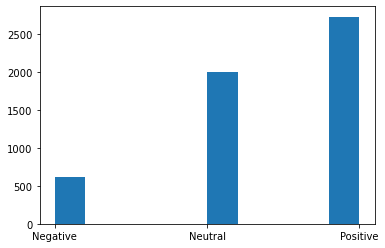

In [290]:
plt.hist(df['TRUE_SENTIMENT'])

### Remove skewness

In [291]:
X = df[['DOCUMENT']].copy()
X = X['DOCUMENT'].astype(str)
print(X.shape)
X.head()

(5339,)


0    Germany's Landesbank Baden Wuertemberg won EU ...
1    The Philippine National Police (PNP) identifie...
2    Sirleaf  70  acknowledged before the commissio...
3    Sawyer logged off and asked her sister  Mari  ...
4    Candi Holyfield said in the protective order t...
Name: DOCUMENT, dtype: object

In [292]:
Y = df['TRUE_SENTIMENT'].copy()
print(Y.shape)
Y.head()

(5339,)


0    Negative
1     Neutral
2    Negative
3     Neutral
4     Neutral
Name: TRUE_SENTIMENT, dtype: object

In [293]:
punctuation = set(string.punctuation) # ,.:''
wordnet_lemmatizer = WordNetLemmatizer()#runs -> run
stopwords_list = stopwords.words('english')#is, the, a, are
stopwords_list.append('br') #linebreak in html, needs removal

In [294]:
def text_prep(text):
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('[^a-z\s]', '', text.lower()) #lower text
    
    #remove punctuation
    punc_removed = [char for char in text if char not in punctuation]
    punc_removed = ''.join(punc_removed)

    #remove stopwords
    no_stopword = [word for word in punc_removed.split() if word not in stopwords_list]
    
    #lemmatizing (runs -> run)
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in no_stopword]
    lemmatized = np.array(lemmatized)
    return lemmatized

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [296]:
X_test

10      Bethune  the Ady Gil skipper  said he was happ...
1945    EDINBURG  Texas -- A former monk has testified...
574     President Trump gave his first State of the Un...
311     If  the Trump administration  starts a trade w...
168     Beyond the question of James and whether it 's...
                              ...                        
2251    These terrifying tales sent me looking for a b...
3127    Anthony Milan Ross  45   was charged with thre...
437     Ji Hyeon-A  was repatriated three times to Nor...
474     LOS ANGELES --  Frances McDormand  won the bes...
2168    Burge was not in court  but  Jackie Wilson   w...
Name: DOCUMENT, Length: 1762, dtype: object

In [297]:
cv= CountVectorizer(analyzer = text_prep, min_df = 10, max_df = 0.95)
cv.fit_transform(X.values)
train_feature_set=cv.transform(X_train.values)
test_feature_set=cv.transform(X_test.values)


In [298]:
y_train_feature_set = cv.transform(y_train.values)

In [299]:
lr = LogisticRegression(random_state = 42, max_iter=10000, multi_class='multinomial', solver='lbfgs')
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)

In [300]:
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
#print("F1: ",round(metrics.f1_score(y_test, y_pred,average='micro')))

Accuracy:  0.476


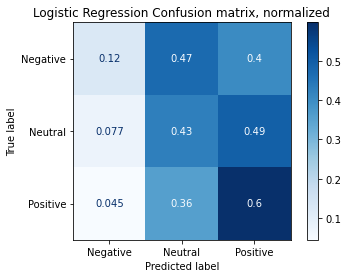

In [301]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Negative', 'Neutral', 'Positive'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, normalized');

In [302]:
X_train

1519    Mariah Carey  undeterred by last yearâs perf...
259     Gus Kenworthy  Nick Goepper advance to men's s...
481     Cliven Bundy  emerged to supportersâ cheers ...
399     Ukrainian Security Service officers detain  Mi...
1023    President Trump used to have kind words for  h...
                              ...                        
3092    President Donald Trump nominated Michigan Stat...
417     An unnamed actress has filed  a lawsuit agains...
431     ISLAMABAD (Reuters) - The ruling Pakistan Musl...
466     PHNOM PENH (Reuters) - Cambodiaâs main oppos...
860     NEW YORK (Reuters Breakingviews) - Time beat t...
Name: DOCUMENT, Length: 3577, dtype: object

### XGBoost

In [303]:
#cv= CountVectorizer(analyzer = text_prep, min_df = 10, max_df = 0.95)
#cv.fit_transform(X.values)

In [335]:
df['DOCUMENT']

0      Germany's Landesbank Baden Wuertemberg won EU ...
1      The Philippine National Police (PNP) identifie...
2      Sirleaf  70  acknowledged before the commissio...
3      Sawyer logged off and asked her sister  Mari  ...
4      Candi Holyfield said in the protective order t...
                             ...                        
574    President Trump gave his first State of the Un...
575    An onslaught of victims  many of them tearful ...
576    The Resilience Of  Victoria Williams\n Victori...
577    Waukesha County Circuit Judge Michael Bohren o...
578    âAnecdotally  I am surprised that there appe...
Name: DOCUMENT, Length: 5339, dtype: object

In [337]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

#CountVec = CountVectorizer(analyzer = text_prep, min_df = 10, max_df = 0.95)
CountVec = CountVectorizer(analyzer = text_prep)
#transform
X = CountVec.fit_transform(df['DOCUMENT'])

#create dataframe
X_df=pd.DataFrame(X.toarray(),columns=CountVec.get_feature_names())


In [338]:
print(X_df.shape)
X_df.head()


(5339, 8275)


,aaron,abandon,abandoned,abandonment,abbas,abc,abe,ability,able,aboard,...,youve,zach,zealand,zero,zimbabwe,zimbabwean,zinke,zone,zuckerberg,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [339]:
le = LabelEncoder()
le.fit(df['TRUE_SENTIMENT'])
print(le.classes_)
Y = le.transform(df['TRUE_SENTIMENT'])
print(Y)

['Negative' 'Neutral' 'Positive']
[0 1 0 ... 2 2 2]


In [340]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_df, Y, test_size=0.3, random_state=42)

In [341]:
print(X_train_bow.shape, y_train_bow.shape)
print(X_test_bow.shape, y_test_bow.shape)

(3737, 8275) (3737,)
(1602, 8275) (1602,)


In [342]:
from xgboost import XGBClassifier
#xgb_bow = XGBClassifier(random_state=42, learning_rate=0.1,use_label_encoder=False)
#xgb_bow.fit(x_train_bow, y_train_bow, eval_set=[(X_test, y_test)])

clf_xbg = XGBClassifier(objective='multi:softmax', missing=None, seed=42, use_label_encoder=False)
clf_xbg.fit(X_train_bow, y_train_bow, verbose=True, early_stopping_rounds=60,  eval_metric='merror',eval_set=[(X_test_bow, y_test_bow)])

[0]	validation_0-merror:0.49688
[1]	validation_0-merror:0.48252
[2]	validation_0-merror:0.48065
[3]	validation_0-merror:0.48252
[4]	validation_0-merror:0.48689
[5]	validation_0-merror:0.47753
[6]	validation_0-merror:0.47815
[7]	validation_0-merror:0.46941
[8]	validation_0-merror:0.47191
[9]	validation_0-merror:0.47004
[10]	validation_0-merror:0.47316
[11]	validation_0-merror:0.47004
[12]	validation_0-merror:0.46504
[13]	validation_0-merror:0.46816
[14]	validation_0-merror:0.47565
[15]	validation_0-merror:0.47253
[16]	validation_0-merror:0.47004
[17]	validation_0-merror:0.46941
[18]	validation_0-merror:0.47253
[19]	validation_0-merror:0.47316
[20]	validation_0-merror:0.46692
[21]	validation_0-merror:0.47253
[22]	validation_0-merror:0.46692
[23]	validation_0-merror:0.47129
[24]	validation_0-merror:0.47129
[25]	validation_0-merror:0.47378
[26]	validation_0-merror:0.47253
[27]	validation_0-merror:0.47066
[28]	validation_0-merror:0.47316
[29]	validation_0-merror:0.46879
[30]	validation_0-me

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [346]:
%%time
y_pred_bow=clf_xbg.predict(X_test_bow)

Wall time: 343 ms


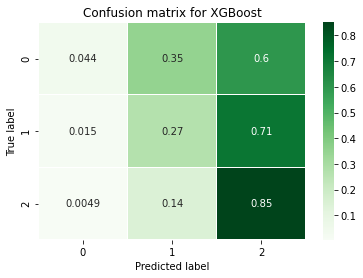

In [347]:
matrix = confusion_matrix(y_test_bow, y_pred_bow)

matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion matrix for XGBoost")
plt.show()

In [348]:
accuracy_score(y_test_bow, y_pred_bow, normalize=True)

0.5349563046192259

In [ ]:
article='''COVID-19 cases across Japan continued to climb July 31 with preliminary figures showing the total already exceeded the previous day's record of 10,743.
In Tokyo, for the first time, the daily count of new cases reached the 4,000 mark on July 31.
Record case numbers were confirmed in at least seven prefectures: Saitama, Kanagawa and Chiba, which are all adjacent to Tokyo, as well as Gunma, Tochigi, Kyoto and Okinawa.
In Saitama Prefecture, the daily tally of new COVID-19 cases exceeded 1,000 for the first time with 1,036. The previous record for Saitama, 869, was logged July 28.
In Kanagawa Prefecture, 1,580 fresh COVID-19 cases were confirmed, the fourth consecutive day to break its daily record.
In Tokyo, the host city of the Summer Olympics, metropolitan government officials said there were a record 4,058 new cases on July 31.
The daily average for the week ending July 31 for Tokyo was 2,920, a staggering 117 percent increase over the previous week.
Among the new patients, 1,484 were in their 20s, followed by 887 in their 30s, 583 in their 40s and 398 in their 50s. Officials said 106 patients were aged at 65 or older.
Ninety-five patients had symptoms serious enough to require the use of a ventilator or other equipment to breathe, up seven from the previous day.
Organizers of the Tokyo Olympics reported 21 new COVID-19 cases among people connected to the Games on July 31.
Fourteen of them worked as contractors, five of whom are from overseas. Seven of them were Olympic-related officials. Sixteen of the 21 patients live in Japan. That brings the number of Olympic-related people who have tested positive to the virus since July 1 to 241.
In Okinawa, the nation's southernmost prefecture, local government officials confirmed a record 439 new COVID-19 cases on July 31.
It was the first time for the daily tally there to exceed 400.'''

In [349]:
X = CountVec.fit_transform([article])

#create dataframe
X_df=pd.DataFrame(X.toarray(),columns=CountVec.get_feature_names())

ValueError: max_df corresponds to < documents than min_df